<a href="https://colab.research.google.com/github/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex/blob/main/Illustration_decoding_methodologies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----------------------------------------------------------------------------
# Generating illustration figures
---


###Please ensure you have downloaded the required data from Figshare before proceeding.

**Google Colab:**



*   Upload the data to your Google Drive.
*   Select Google Drive in the widget below and mount your drive for the fastest access.




**Kaggle:**

*   Add the dataset to your notebook's Input directory (e.g., ../input/dataset-name).

*   Select Kaggle Input in the widget below.

**Local Computer:**

*   Store the downloaded files in a folder on your machine.

*   Select Local Storage in the widget below and paste the absolute path to that folder (e.g., /Users/name/data/).

In [ ]:
# ──────────────────────────────────────────────────────────────────────
# DATA SETUP WIDGET (Universal: Colab, Kaggle & Local)
# ──────────────────────────────────────────────────────────────────────
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
import shutil
from pathlib import Path

# --- 1. CONFIGURATION
REQUIRED_FILES = [
    'Spike_count_even_sessions.npy',
    'Spike_count_odd_sessions.npy',
    'hvm_public_extended_meta.csv' ,
    'high_variation_stimuli.zip',
    'deepNetFeatures.zip',
    'background_variations_images.zip',
]
DEST_DIR = Path("downloads")
DEST_DIR.mkdir(exist_ok=True)

# Detect Environment
IN_COLAB = 'google.colab' in str(get_ipython())
IN_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

# --- UI Elements ---
style = {'description_width': '120px'}
layout_full = widgets.Layout(width='98%')

header = widgets.HTML("<h2>📂 Data Import Manager</h2>")

# Determine options based on environment
options = ['Local Upload']
if IN_COLAB:
    options = ['Google Drive', 'Local Upload']
elif IN_KAGGLE:
    options = ['Kaggle Input', 'Local Upload']
else:
    options = ['Local Storage', 'Local Upload']

source_toggle = widgets.ToggleButtons(
    options=options,
    description='Select Source:',
    button_style='info',
    style=style
)

# Input for Paths
path_input = widgets.Text(
    value='/content/drive/MyDrive/vlPFC_Geometry' if IN_COLAB else '.',
    placeholder='Enter absolute path to data folder...',
    description='Data Path:',
    disabled=False,
    layout=layout_full,
    style=style
)

btn_action = widgets.Button(
    description='Start Import',
    button_style='primary',
    icon='download',
    layout=widgets.Layout(width='200px')
)

out_log = widgets.Output(layout={'border': '1px solid #ddd', 'padding': '10px'})

# --- Logic ---
def update_ui(change):
    # Hide path input if 'Local Upload' (manual) is selected
    if source_toggle.value == 'Local Upload':
        path_input.layout.display = 'none'
    else:
        path_input.layout.display = 'flex'
        # Auto-update description based on selection
        if source_toggle.value == 'Google Drive':
            path_input.description = 'Drive Path:'
        elif source_toggle.value == 'Local Storage':
            path_input.description = 'Local Path:'
        elif source_toggle.value == 'Kaggle Input':
            path_input.description = 'Input Path:'
            # Common default path for Kaggle datasets
            path_input.value = '/kaggle/input/vlpfc-geometry'

source_toggle.observe(update_ui, 'value')

def on_click_action(b):
    with out_log:
        clear_output()
        mode = source_toggle.value

        # 1. Handle "Local Upload" (Colab only)
        if mode == 'Local Upload':
            if IN_COLAB:
                from google.colab import files
                print("🚀 Upload files now (select all required files):")
                uploaded = files.upload()
                for name in uploaded:
                    shutil.move(name, DEST_DIR / name)
                print("\n✅ Upload complete.")
            else:
                print("⚠️ Manual upload widget is Colab-only.")
                print(f"👉 Please manually copy files to: {DEST_DIR.absolute()}")
            return

        # 2. Handle Path-based imports (Drive, Local, Kaggle)
        src_path = Path(path_input.value)

        if mode == 'Google Drive' and not src_path.exists():
            from google.colab import drive
            print("🔄 Mounting Google Drive...")
            drive.mount('/content/drive')

        if not src_path.exists():
            print(f"❌ Error: Path not found: {src_path}")
            return

        print(f"🔎 Scanning {src_path} for files...")

        for fname in REQUIRED_FILES:
            dest = DEST_DIR / fname
            if dest.exists():
                print(f"   • {fname}: Already exists (Skipping)")
                continue

            # A. Try to find the exact file first
            found = list(src_path.rglob(fname))

            if found:
                print(f"   • Copying {fname}...", end=" ")
                shutil.copy(found[0], dest)
                print("Done.")

            # B. If not found, and it is a zip, look for the unzipped folder (Kaggle scenario)
            elif fname.endswith('.zip'):
                folder_name = Path(fname).stem # 'deepNetFeatures' from 'deepNetFeatures.zip'

                # Look for a directory with that name
                found_dirs = list(src_path.rglob(folder_name))
                # Ensure it is actually a directory
                found_dirs = [d for d in found_dirs if d.is_dir()]

                if found_dirs:
                    print(f"   • Found extracted folder '{folder_name}'. Re-zipping to {fname}...", end=" ")
                    # shutil.make_archive expects the base name (no extension) and the root dir
                    shutil.make_archive(str(DEST_DIR / folder_name), 'zip', found_dirs[0])
                    print("Done.")
                else:
                    print(f"   ❌ {fname}: Not found (checked for file and unzipped folder).")
            else:
                print(f"   ❌ {fname}: Not found in source path.")

        # Verification
        missing = [f for f in REQUIRED_FILES if not (DEST_DIR / f).exists()]
        if not missing:
            print("\n🎉 Success! All files are in 'downloads/'. Run the next cell.")
        else:
            print(f"\n⚠️ Missing files: {missing}")

# Initial Setup
update_ui(None)
btn_action.on_click(on_click_action)

# Display Widget
display(header, source_toggle, path_input, btn_action, out_log)

# First, download data and import toolboxes

In [11]:
import os, re, pickle, warnings, time
from pathlib import Path
from itertools import combinations
import sys
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy.stats import binomtest
from statsmodels.stats.multitest import multipletests
from pathlib import PurePath
from scipy.stats import gaussian_kde
import jax.numpy as jnp
from jax import jit
# Determine the path to the repository based on the environment
IN_COLAB = False
IN_KAGGLE = False # Assuming not in Kaggle for now
try:
    if 'google.colab' in str(get_ipython()):
        IN_COLAB = True
except NameError:
    pass

if IN_COLAB:
    path_to_repo = '/content/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
elif IN_KAGGLE:
    path_to_repo = '/kaggle/working/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
else:
    # Assume local environment where the .py file is in the root of the repo
    path_to_repo = '.'

# Only clone if not already present
if not os.path.exists(path_to_repo):
    os.system("git clone https://github.com/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex.git " + path_to_repo)

sys.path.append(path_to_repo)
sys.path.append(os.path.join(path_to_repo, 'utils'))

from extract_and_download_data import unzip
from image_processing import m_pathway_filter_gaussian

FIG_DIR = Path("Figures") # Convert to Path object
os.makedirs(FIG_DIR, exist_ok=True)
CACHE_DIR = Path(".cache");   CACHE_DIR.mkdir(exist_ok=True) # From Category decoding

# Define the directory where files are downloaded
DOWNLOAD_DIR = Path("downloads") # Convert to Path object
os.makedirs(DOWNLOAD_DIR, exist_ok=True)


# ──────────────────────────────────────────────────────────────────────
# Load spike data (Data assumed to be in 'downloads/')
# ──────────────────────────────────────────────────────────────────────
DOWNLOAD_DIR = Path("downloads")
even_path = DOWNLOAD_DIR / "Spike_count_even_sessions.npy"
odd_path  = DOWNLOAD_DIR / "Spike_count_odd_sessions.npy"

if not (even_path.exists() and odd_path.exists()):
    print("⚠️ Spike data not found. Please run the Data Import Widget above.")
else:
    print("Loading spike data...")
    even_full = np.load(even_path)
    odd_full  = np.load(odd_path)
    print(f"Loaded: Even {even_full.shape}, Odd {odd_full.shape}")

meta_downloaded_path = DOWNLOAD_DIR / "hvm_public_extended_meta.csv" # Use Path object
dnn_zip_downloaded_path = DOWNLOAD_DIR / "deepNetFeatures.zip" # Use Path object
even_downloaded_path = DOWNLOAD_DIR / "Spike_count_even_sessions.npy" # Use Path object
odd_downloaded_path = DOWNLOAD_DIR / "Spike_count_odd_sessions.npy" # Use Path object


meta_downloaded = meta_downloaded_path.exists()
dnn_zip_downloaded = dnn_zip_downloaded_path.exists()
even_downloaded_check = even_downloaded_path.exists()
odd_downloaded_check = odd_downloaded_path.exists()


if not (meta_downloaded and dnn_zip_downloaded):
    print("Failed to download necessary files. Exiting.")
    # exit() # Do not exit, just skip the parts that require these files

if dnn_zip_downloaded:
    # Update unzip to use the downloaded zip path and specify the extraction directory
    unzip(dnn_zip_downloaded_path, "deepNetFeatures")

Loading spike data...
Loaded: Even (3200, 96, 20), Odd (3200, 96, 20)
Unzipping downloads/deepNetFeatures.zip...
Unzip successful.


# Illustration of methodology

## Object-generalizing category information

Saved:
  Figures/method_LOO_train_test_grid_generalisation_LSF.png 
  Figures/method_LOO_train_test_grid_generalisation_LSF.svg


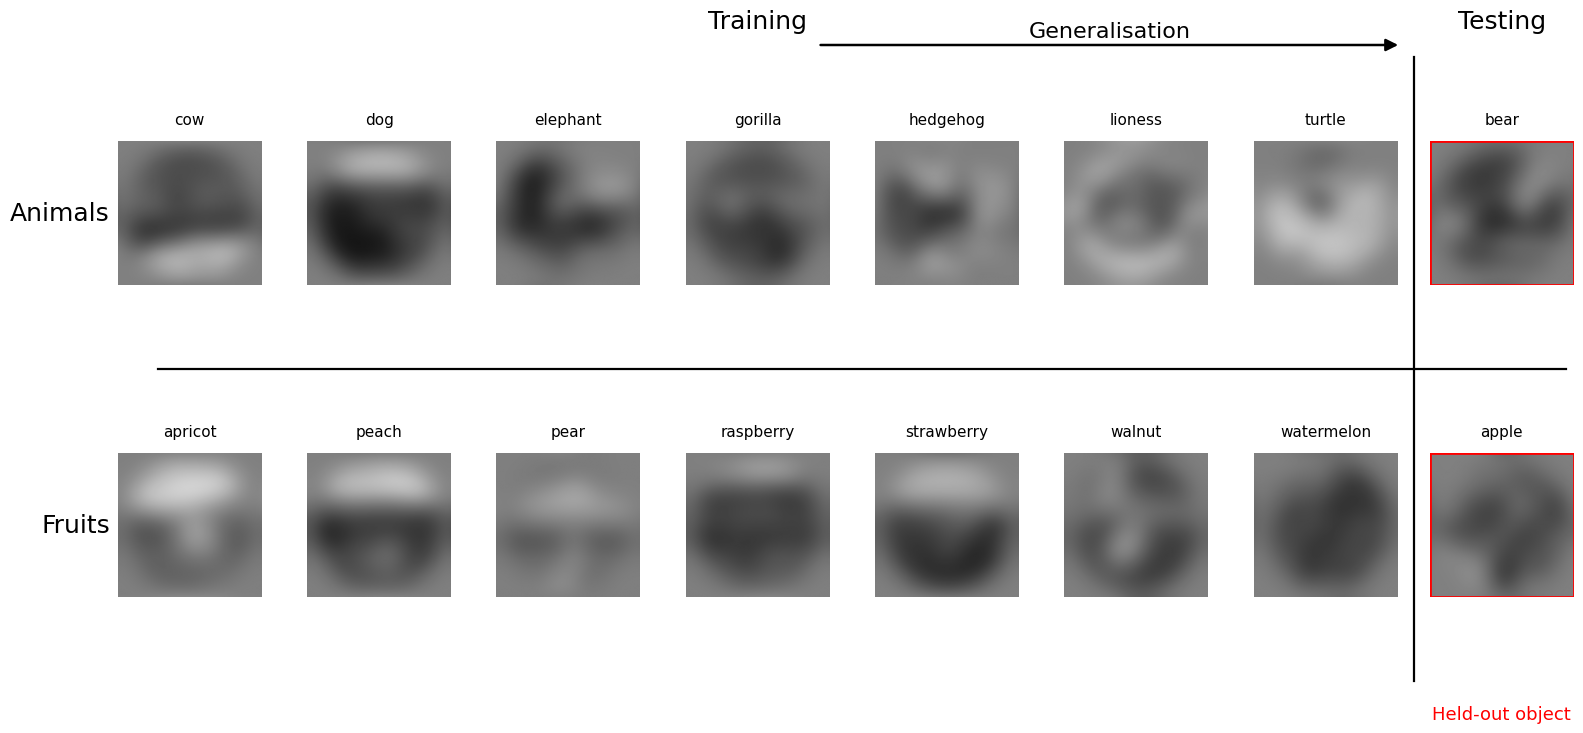

In [13]:
# ─────────────────────────────────────────────────────────────────────────────
# Generalisation panel (LSF-blurred): leave-one-object-per-category out
# ─────────────────────────────────────────────────────────────────────────────

import io, zipfile, sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Rectangle
from matplotlib.lines import Line2D
from PIL import Image, ImageOps

plt.rcParams.update({"svg.fonttype": "none"})  # keep text as text in SVG

# ------------------------- Config -------------------------
DOWNLOAD_DIR = Path("downloads")
FIG_DIR      = Path("Figures")
META_CSV     = DOWNLOAD_DIR / "hvm_public_extended_meta.csv"
ZIP_HIGH     = DOWNLOAD_DIR / "high_variation_stimuli.zip"

CAT1, CAT2 = "Animals", "Fruits"
HOLDOUT1, HOLDOUT2 = None, None

THUMB_SIZE      = (140, 140)
MIN_TRAIN_COLS  = 6
FIGSIZE         = (16, 8)

# LSF filter params
FOV_DEG         = 8.0
CUTOFF_CPD      = 0.5
ATTEN_DB_ATCUT  = -20

# ------------------------- IO helpers -------------------------
def open_zip(zip_path: Path) -> zipfile.ZipFile:
    if not zip_path.exists():
        raise FileNotFoundError(f"Missing archive: {zip_path}")
    return zipfile.ZipFile(zip_path, "r")

def load_meta_high_variation(meta_csv: Path) -> pd.DataFrame:
    meta = pd.read_csv(meta_csv)
    meta["base"] = meta["filename"].str.replace(r"\.\w+$", "", regex=True)
    # Keep high-variation subset (skip first 640 background-only rows)
    return meta.iloc[np.arange(640, len(meta))].reset_index(drop=True)

def load_grayscale_from_zip(zf: zipfile.ZipFile, base_stem: str, resize=THUMB_SIZE):
    target = f"{base_stem}.png"
    for name in zf.namelist():
        if name.endswith(target):
            with zf.open(name) as fh:
                im = Image.open(io.BytesIO(fh.read())).convert("L")
                im = ImageOps.contain(im, resize)
                return np.asarray(im)
    return None

def representative_blurred(df_subset: pd.DataFrame, category: str, object_name: str, zf: zipfile.ZipFile):
    rows = df_subset.query("category_name == @category and object_name == @object_name")
    if rows.empty:
        return None
    base = rows.iloc[0]["base"]
    arr  = load_grayscale_from_zip(zf, base, resize=THUMB_SIZE)
    if arr is None:
        return None
    lp   = m_pathway_filter_gaussian(arr.astype(float),
                                     cutoff_cpd=CUTOFF_CPD,
                                     fov_deg=FOV_DEG,
                                     atten_dB_at_cut=ATTEN_DB_ATCUT)
    return np.clip(lp, 0, 255).astype(np.uint8)

# ---------------------- Build split & images -----------------------
meta_hv = load_meta_high_variation(META_CSV)
with open_zip(ZIP_HIGH) as zf:
    avail = meta_hv["category_name"].unique().tolist()
    if CAT1 not in avail or CAT2 not in avail:
        raise ValueError(f"Categories must be among {avail}, got ({CAT1}, {CAT2}).")

    objs1 = sorted(meta_hv.query("category_name == @CAT1")["object_name"].unique())
    objs2 = sorted(meta_hv.query("category_name == @CAT2")["object_name"].unique())
    if HOLDOUT1 is None: HOLDOUT1 = objs1[0]
    if HOLDOUT2 is None: HOLDOUT2 = objs2[0]
    if HOLDOUT1 not in objs1: raise ValueError(f"holdout1 '{HOLDOUT1}' not in {objs1}")
    if HOLDOUT2 not in objs2: raise ValueError(f"holdout2 '{HOLDOUT2}' not in {objs2}")

    pair_mask = meta_hv["category_name"].isin([CAT1, CAT2])
    df_pair   = meta_hv[pair_mask].copy()
    is_test   = ((df_pair["category_name"] == CAT1) & (df_pair["object_name"] == HOLDOUT1)) | \
                ((df_pair["category_name"] == CAT2) & (df_pair["object_name"] == HOLDOUT2))
    df_test, df_train = df_pair[is_test], df_pair[~is_test]

    train_imgs_c1 = {}
    for o in objs1:
        if o == HOLDOUT1: continue
        im = representative_blurred(df_train, CAT1, o, zf)
        if im is not None: train_imgs_c1[o] = im

    train_imgs_c2 = {}
    for o in objs2:
        if o == HOLDOUT2: continue
        im = representative_blurred(df_train, CAT2, o, zf)
        if im is not None: train_imgs_c2[o] = im

    test_img_c1 = {}
    im = representative_blurred(df_test, CAT1, HOLDOUT1, zf)
    if im is not None: test_img_c1[HOLDOUT1] = im

    test_img_c2 = {}
    im = representative_blurred(df_test, CAT2, HOLDOUT2, zf)
    if im is not None: test_img_c2[HOLDOUT2] = im

# ----------------------------- Plot helpers ------------------------
def label_above(fig, x_center, y_top, text, fontsize=11, pad=0.008):
    """Place a label above a thumbnail using figure coordinates."""
    fig.text(x_center, y_top + pad, text, ha="center", va="bottom", fontsize=fontsize)

def place_training_row(fig, images_dict, band_bottom, band_top,
                       area_left, area_right, min_cols=MIN_TRAIN_COLS,
                       box_w=0.09, box_h=0.20):
    """Place thumbnails within a horizontal band [band_bottom, band_top] (figure coords)."""
    keys = sorted(images_dict.keys())
    if not keys: return
    # keep a safety pad so images do not touch the separation line
    vpad = 0.015
    y_center = (band_bottom + band_top) / 2.0
    box_h = min(box_h, (band_top - band_bottom) - 2*vpad)
    y0 = y_center - box_h/2.0

    n = len(keys)
    cols = max(min_cols, n)
    xs_all = np.linspace(area_left + 0.02, area_right - 0.02, cols)
    if n < cols:
        start = (cols - n)//2
        xs = xs_all[start:start+n]
    else:
        xs = np.linspace(area_left + 0.02, area_right - 0.02, n)

    for x, k in zip(xs, keys):
        x0 = x - box_w/2.0
        ax = fig.add_axes([x0, y0, box_w, box_h])
        ax.imshow(images_dict[k], cmap="gray", vmin=0, vmax=255)
        ax.set_axis_off()
        label_above(fig, x, y0 + box_h, k, fontsize=11)

def place_test_single(fig, image_dict, x_center, band_bottom, band_top,
                      box_w=0.09, box_h=0.20):
    if not image_dict: return
    vpad = 0.015
    y_center = (band_bottom + band_top) / 2.0
    box_h = min(box_h, (band_top - band_bottom) - 2*vpad)
    y0 = y_center - box_h/2.0

    (name, im), = image_dict.items()
    ax = fig.add_axes([x_center - box_w/2.0, y0, box_w, box_h])
    ax.imshow(im, cmap="gray", vmin=0, vmax=255)
    ax.set_axis_off()
    label_above(fig, x_center, y0 + box_h, name, fontsize=11)
    ax.add_patch(Rectangle((0,0),1,1, transform=ax.transAxes,
                           lw=2, edgecolor="red", facecolor="none"))

# ----------------------------- Plot -------------------------------
fig = plt.figure(figsize=FIGSIZE)

# Full-figure coordinates
L, R = 0.10, 0.98
B, T = 0.12, 0.90

left_w, right_w = 0.75, 0.18
xsplit = L + left_w
mid    = (T + B) / 2.0

# Draw separation lines in FIGURE COORDINATES (no overlap issues)
fig.add_artist(Line2D([L, R], [mid, mid], lw=1.6, color="black", zorder=5, transform=fig.transFigure))
fig.add_artist(Line2D([xsplit +.035, xsplit +.035], [B, T], lw=1.6, color="black", zorder=5, transform=fig.transFigure))

# Headers (figure coords)
fig.text(L + left_w/2.0, T + 0.03, "Training", ha="center", va="bottom", fontsize=18)
fig.text(xsplit + right_w/2.0, T + 0.03, "Testing",  ha="center", va="bottom", fontsize=18)

# Arrow + label (figure coords)
xs, xe = L + left_w*0.55, xsplit + right_w*0.15
fig.patches.append(FancyArrowPatch((xs, T + 0.015), (xe, T + 0.015),
                                   arrowstyle='-|>', mutation_scale=18, lw=1.8,
                                   color="black", transform=fig.transFigure))
fig.text((xs + xe)/2.0, T + 0.02, "Generalisation", ha="center", va="bottom", fontsize=16)

# Category labels (figure coords)
fig.text(L - 0.03, (T + mid)/2.0, CAT1, ha="right", va="center", fontsize=18)
fig.text(L - 0.03, (mid + B)/2.0, CAT2, ha="right",  va="center", fontsize=18)

# Training rows (blurred thumbnails) — use bands with padding to avoid the mid line
place_training_row(fig, train_imgs_c1, band_bottom=mid+0.02, band_top=T-0.02,
                   area_left=L, area_right=xsplit, min_cols=MIN_TRAIN_COLS)
place_training_row(fig, train_imgs_c2, band_bottom=B+0.02,  band_top=mid-0.02,
                   area_left=L, area_right=xsplit, min_cols=MIN_TRAIN_COLS)

# Test column (blurred held-out)
x_center = xsplit + right_w/2.0
place_test_single(fig, test_img_c1, x_center=x_center,
                  band_bottom=mid+0.02, band_top=T-0.02)
place_test_single(fig, test_img_c2, x_center=x_center,
                  band_bottom=B+0.02,  band_top=mid-0.02)

# Legend
fig.text(x_center, B - 0.03, "Held-out object", ha="center", va="top", fontsize=13, color="red")

FIG_DIR.mkdir(parents=True, exist_ok=True)
out_png = FIG_DIR / "method_LOO_train_test_grid_generalisation_LSF.png"
out_svg = FIG_DIR / "method_LOO_train_test_grid_generalisation_LSF.svg"
fig.savefig(out_png, dpi=200, bbox_inches="tight")
fig.savefig(out_svg, bbox_inches="tight")
print("Saved:\n ", out_png, "\n ", out_svg)

## Illustration of decoding crossvalidation

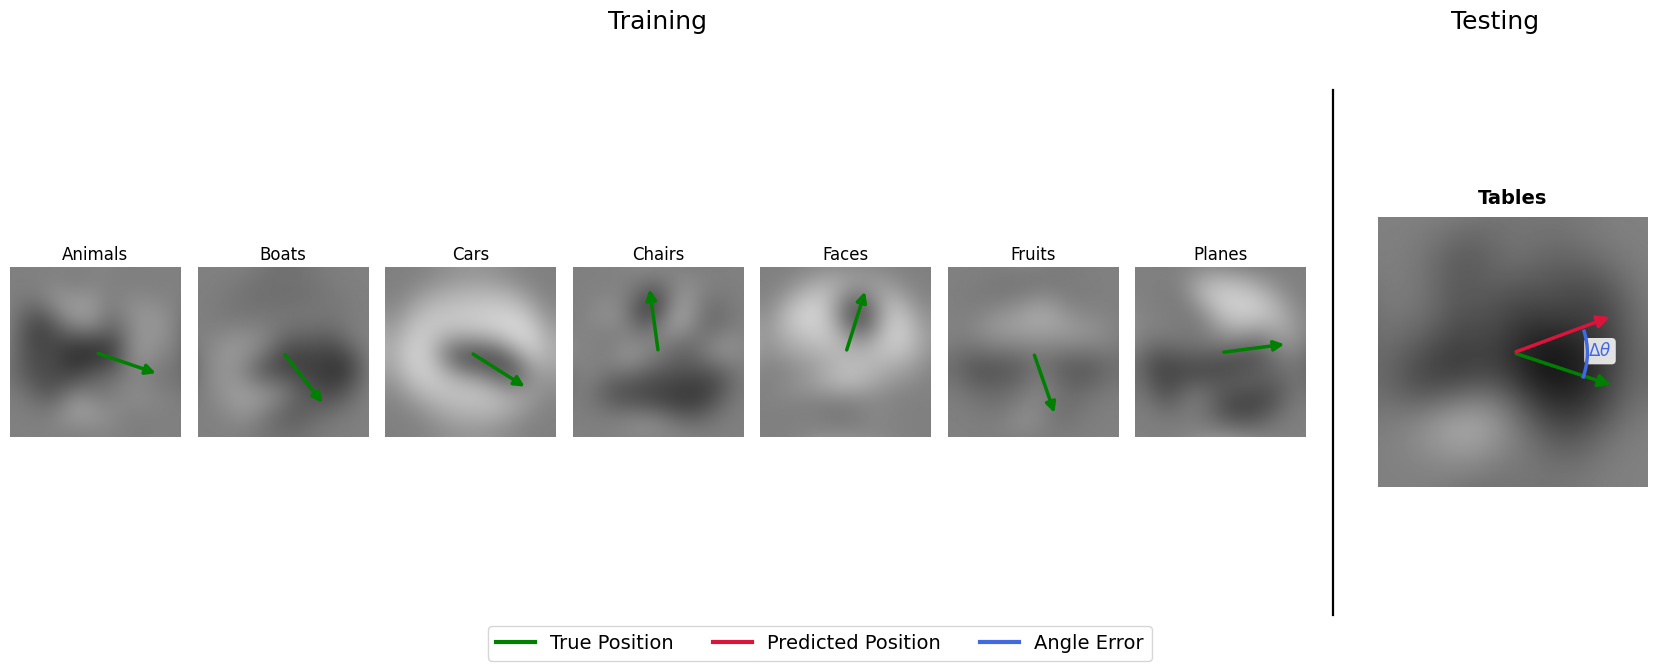

In [12]:
import io
import zipfile
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Arc
from matplotlib.lines import Line2D
from PIL import Image, ImageOps
from matplotlib import rcParams
from fractions import Fraction

# --- Configuration ---
DOWNLOAD_DIR = Path("downloads")
FIG_DIR = Path("Figures")
META_CSV = DOWNLOAD_DIR / "hvm_public_extended_meta.csv"
ZIP_HIGH = DOWNLOAD_DIR / "high_variation_stimuli.zip"
FOV_DEG = 8.0  # Field-of-view for Gaussian filter

FIG_DIR.mkdir(parents=True, exist_ok=True)
DOWNLOAD_DIR.mkdir(parents=True, exist_ok=True)

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

# --- IO and Image Helpers ---
def open_zip(zip_path: Path) -> zipfile.ZipFile:
    if not zip_path.exists():
        print(f"Warning: ZIP file not found at {zip_path}. Using placeholder images.")
        return None
    return zipfile.ZipFile(zip_path, "r")

def load_meta_high_variation(meta_csv: Path) -> pd.DataFrame:
    if not meta_csv.exists():
        raise FileNotFoundError(f"Missing metadata file: {meta_csv}")
    meta = pd.read_csv(meta_csv)
    meta["base"] = meta["filename"].str.replace(r"\.\w+$", "", regex=True)
    # NOTE: metadata stores centroid_x / centroid_y; code below uses (row, col)=(y, x)
    return meta.iloc[np.arange(640, len(meta))].reset_index(drop=True)

def load_grayscale_from_zip(zf: zipfile.ZipFile, base_stem: str):
    if zf is None: return None
    resize_dim = (256, 256)
    target = f"{base_stem}.png"
    for name in zf.namelist():
        if name.endswith(target):
            with zf.open(name) as fh:
                im = Image.open(io.BytesIO(fh.read())).convert("L")
                im = im.resize(resize_dim, Image.Resampling.LANCZOS)
                return np.asarray(im)
    return None

def get_representative_blurred_images(df: pd.DataFrame, zf: zipfile.ZipFile, categories: list):
    """Fetches a representative image, blurs it, and gets its centroid (row, col) = (y, x)."""
    data = {}
    for cat in categories:
        row = df[df["category_name"] == cat].iloc[0]
        base = row["base"]
        # Store as (row, col) i.e. (y, x) for image indexing
        centroid_rc = (row["centroid_y"], row["centroid_x"])
        original_img = load_grayscale_from_zip(zf, base)

        if original_img is None:
            blurred_img = np.full((256, 256), 128, dtype=np.uint8)
            centroid_rc = (128, 128)
        else:
            # Assumes you have this function in your workspace
            blurred_img = m_pathway_filter_gaussian(original_img, fov_deg=FOV_DEG)

        data[cat] = {"image": blurred_img, "centroid": centroid_rc}
    return data

# --- Angle utilities ---
def angle_deg_from_center_image_coords(point_rc, center_rc=(128, 128)):
    """
    Angle in degrees from center to point, using standard cartesian convention.
    Image has (row, col) with y down, so invert vertical.
    """
    r, c = point_rc
    cr, cc = center_rc
    dx = c - cc
    dy = cr - r  # invert sign for image coords
    return np.degrees(np.arctan2(dy, dx)) % 360.0

def minor_signed_delta(a_deg, b_deg):
    """Signed smallest difference b - a in degrees, in (-180, 180]."""
    return ((b_deg - a_deg + 180) % 360) - 180

def polar_to_image_xy(angle_deg, radius, center_rc=(128, 128)):
    """Polar (deg, radius) → image coords (x=col, y=row) with y-down."""
    cr, cc = center_rc
    rad = np.radians(angle_deg)
    x = cc + radius * np.cos(rad)
    y = cr - radius * np.sin(rad)
    return x, y



# --- Plotting Helpers ---
def plot_training_image(ax, data, label):
    ax.imshow(data["image"], cmap='gray', vmin=0, vmax=255)
    ax.axis('off')
    centroid = data["centroid"]  # (row, col)
    vec = np.array(centroid) - np.array([128, 128])
    nrm = np.linalg.norm(vec)
    dir_vec = vec / nrm if nrm > 0 else np.array([0, 0])
    end = np.array([128, 128]) + dir_vec * 100

    ax.add_patch(FancyArrowPatch((128, 128), end,
                                 arrowstyle='-|>', mutation_scale=15, lw=2.5, color='green'))
    ax.set_title(label, fontsize=12, pad=5)

def plot_test_image(ax, data, label):
    ax.imshow(data["image"], cmap='gray', vmin=0, vmax=255)
    ax.axis('off')
    for spine in ax.spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(2.5)
        spine.set_visible(True)

    center = (128, 128)

    # ---- Arrows (unchanged) ----
    true_rc = data["centroid"]  # (row, col)
    vec_t = np.array(true_rc) - np.array(center)
    n_t = np.linalg.norm(vec_t)
    dir_t = vec_t / n_t if n_t > 0 else np.array([0, 0])
    end_t = np.array(center) + dir_t * 100

    # Simulated predicted centroid (example)
    pred_rc_sim = (true_rc[0] + 20, true_rc[1] - 30)
    vec_p = np.array(pred_rc_sim) - np.array(center)
    n_p = np.linalg.norm(vec_p)
    dir_p = vec_p / n_p if n_p > 0 else np.array([0, 0])
    end_p = np.array(center) + dir_p * 100

    ax.add_patch(FancyArrowPatch(center, end_t, arrowstyle='-|>', mutation_scale=18, lw=2.5, color='green'))
    ax.add_patch(FancyArrowPatch(center, end_p, arrowstyle='-|>', mutation_scale=18, lw=2.5, color='crimson'))


    true_swapped_rc = (true_rc[1], true_rc[0])
    pred_swapped_rc = (pred_rc_sim[1], pred_rc_sim[0])

    theta_true = angle_deg_from_center_image_coords(true_swapped_rc, center)
    theta_pred = angle_deg_from_center_image_coords(pred_swapped_rc, center)
    dtheta = minor_signed_delta(theta_true, theta_pred)
    theta2 = theta_true + dtheta
    theta1_draw, theta2_draw = (theta_true, theta2) if dtheta >= 0 else (theta2, theta_true)

    arc_radius = 70
    arc = Arc((center[1], center[0]),
              width=2*arc_radius, height=2*arc_radius,
              angle=0, theta1=theta1_draw, theta2=theta2_draw,
              lw=2.5, color='royalblue', zorder=5)
    ax.add_patch(arc)

    # Label as a fraction of π
    mid_angle = (theta1_draw + theta2_draw) / 2.0
    tx, ty = polar_to_image_xy(mid_angle, arc_radius + 12, center)
    ax.text(tx, ty, rf"$\Delta\theta$",
            fontsize=12, color='royalblue', ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='none', alpha=0.85))

    ax.set_title(label, fontsize=14, pad=10, weight='bold')

# --- Main Script ---
meta_hv = load_meta_high_variation(META_CSV)
zip_file = open_zip(ZIP_HIGH)
categories = sorted(meta_hv["category_name"].unique())

train_cats, test_cat = categories[:7], categories[7]
train_data = get_representative_blurred_images(meta_hv, zip_file, train_cats)
test_data = get_representative_blurred_images(meta_hv, zip_file, [test_cat])
if zip_file: zip_file.close()

fig = plt.figure(figsize=(18, 7))
L, R, B, T = 0.05, 0.98, 0.1, 0.85
xsplit = L + 0.72
fig.add_artist(Line2D([xsplit + 0.015, xsplit + 0.015], [B, T], lw=1.6, color="black", zorder=5))

fig.text((L + xsplit)/2, T + 0.08, "Training", ha="center", va="bottom", fontsize=18)
fig.text((xsplit + R)/2, T + 0.08, "Testing",  ha="center", va="bottom", fontsize=18)

grid_spec_train = fig.add_gridspec(1, 7, left=L, right=xsplit, bottom=B, top=T, wspace=0.1)
for i, cat in enumerate(train_cats):
    ax = fig.add_subplot(grid_spec_train[0, i])
    plot_training_image(ax, train_data[cat], cat)

grid_spec_test = fig.add_gridspec(1, 1, left=xsplit + 0.04, right=R - 0.02, bottom=B, top=T)
ax_test = fig.add_subplot(grid_spec_test[0, 0])
plot_test_image(ax_test, test_data[test_cat], f"{test_cat}")

legend_elements = [
    Line2D([0], [0], color='green',   lw=3, label='True Position'),
    Line2D([0], [0], color='crimson', lw=3, label='Predicted Position'),
    Line2D([0], [0], color='royalblue', lw=3, label='Angle Error')
]
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=3, fontsize=14)

out_png = FIG_DIR / "illustration_position_decoding_blurred.png"
out_svg = FIG_DIR / "illustration_position_decoding_blurred.svg"
out_pdf = FIG_DIR / "illustration_position_decoding_blurred.pdf"
fig.savefig(out_pdf, dpi=300)
fig.savefig(out_png, dpi=200, bbox_inches="tight")
fig.savefig(out_svg, bbox_inches="tight")
plt.show()

# Distance to object prototype

## Illustration of hypothesis

Figure saved to Figures/schema_images_generated.pdf


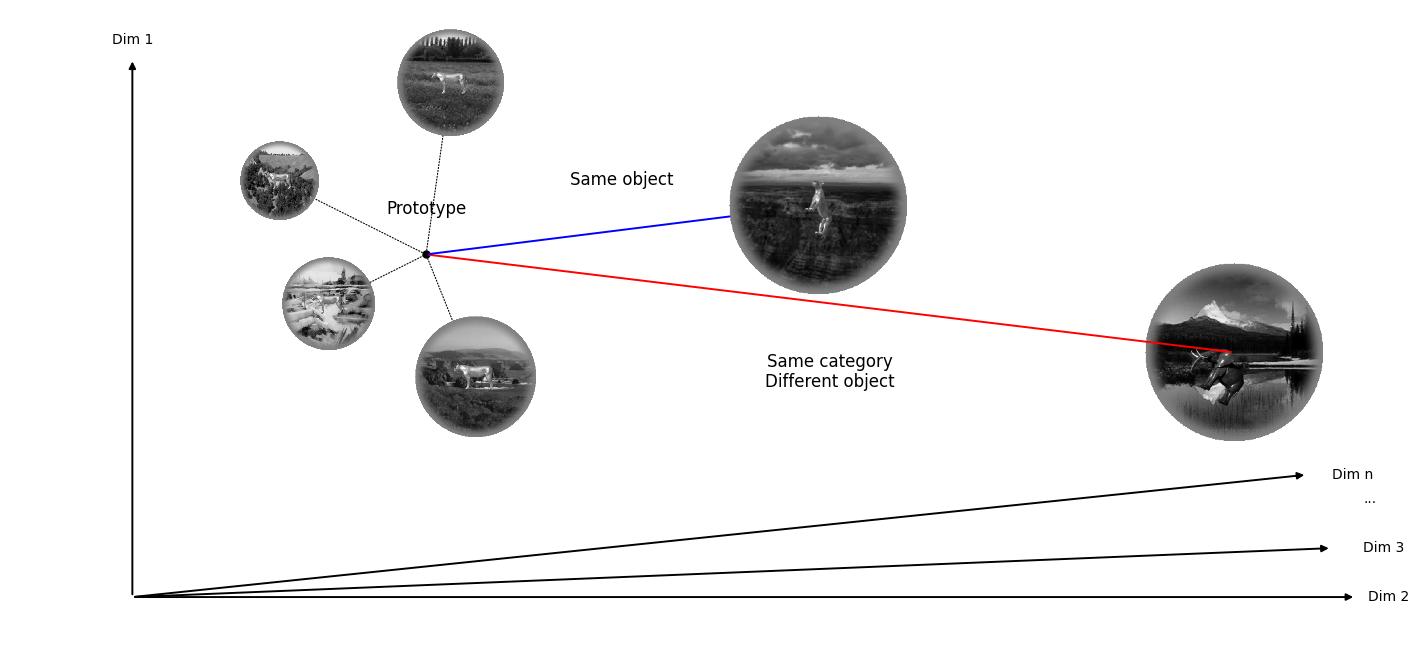

In [16]:
CATEGORY        = "animal"      # one of meta.category_name
OBJ_MAIN        = "lioness"      # object shown in LOW + HIGH-same-object
OBJ_OTHER       = "elephant"     # another object from the same category

# 2-D coordinates (Dim-1 vs Dim-50 plane, arbitrary units)
PROTOTYPE_PT    = (1.2, 1.4)
LOW_COORDS      = [(0.6, 1.70), (1.3, 2.1), (0.8, 1.20), (1.4, .9)]
HIGH_SAME_COORD = (2.8, 1.60)
HIGH_DIFF_COORD = (4.5, 1)

# Relative image size
LOW_ZOOMS        = (0.22, .3, 0.26, 0.34)
HIGH_ZOOMS       = (.5, 0.5)

# Data file names (change if yours differ)
META_CSV        = "downloads/hvm_public_extended_meta.csv"
ZIP_LOW         = "downloads/background_variations_images.zip"
ZIP_HIGH        = "downloads/high_variation_stimuli.zip"
OUT_FIG         = "Figures/schema_images_generated.pdf"

# How to treat pixels outside the circular aperture: "alpha" (transparent) or "white"
APERTURE_MODE   = "alpha"   # change to "white" if you prefer white background
APERTURE_RADIUS = 128       # images are 256x256, circle centered

# ======================================================================
import io, random, zipfile, os, sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import FancyBboxPatch
from PIL import Image
import numpy as np
np.random.seed(42)

# ---------- Helper: load PNG by SHA-1 inside a zip (search subfolders) --
def load_image_from_zip(zfile: zipfile.ZipFile, sha_png: str):
    for name in zfile.namelist():
        if name.endswith(sha_png):
            with zfile.open(name) as f:
                return Image.open(io.BytesIO(f.read()))
    return None

# ---------- Aperture processing: make outside-circle transparent/white ------
def apply_circular_aperture(img: Image.Image,
                            radius: int = APERTURE_RADIUS,
                            mode: str = APERTURE_MODE) -> Image.Image:
    """
    Ensures RGBA and sets alpha=0 (or RGB=255) for pixels outside a centered circle.
    Assumes square 256x256, but works for any square image by using min dimension.
    """
    img = img.convert("RGBA")
    arr = np.array(img)
    h, w = arr.shape[:2]
    cx, cy = w // 2, h // 2
    r = min(radius, cx, cy)

    # boolean mask for pixels INSIDE the circle
    yy, xx = np.ogrid[:h, :w]
    inside = (xx - cx) ** 2 + (yy - cy) ** 2 <= r * r

    if mode.lower() == "alpha":
        # punch out: transparent outside
        arr[~inside, 3] = 0
    else:
        # white outside, keep alpha=255
        arr[~inside, :3] = 255
        arr[~inside, 3] = 255

    return Image.fromarray(arr)

# ---------- Load metadata & archives -----------------------------------
if not os.path.exists(META_CSV):
    sys.exit(f"Metadata file '{META_CSV}' not found.")
meta = pd.read_csv(META_CSV)

try:
    zip_low  = zipfile.ZipFile(ZIP_LOW)
    zip_high = zipfile.ZipFile(ZIP_HIGH)
except FileNotFoundError as e:
    sys.exit(e)

# Helper to embed image
def add_image(img, xy, zoom):
    if img is None:
        rect = FancyBboxPatch((xy[0]-0.14, xy[1]-0.14), 0.28, 0.28,
                              boxstyle="round,pad=0.02", edgecolor='red', facecolor='white')
        ax.add_patch(rect)
        ax.text(*xy, "MISSING", ha='center', va='center', fontsize=6)
        return
    # Matplotlib can take a PIL image; keep frame off to respect alpha
    ab = AnnotationBbox(OffsetImage(img, zoom=zoom), xy, frameon=False, pad=0)
    ax.add_artist(ab)

# ---------- Pick exemplar filenames ------------------------------------
def pick_images(obj_name, variation, k):
    rows = meta[(meta.object_name == obj_name) & (meta.variation == variation)]
    if len(rows) < k:
        sys.exit(f"Not enough images for '{obj_name}', variation {variation}")
    return random.sample(rows["filename"].tolist(), k)

sha_low  = pick_images(OBJ_MAIN, 0, 4)       # four low-variation
sha_same = pick_images(OBJ_MAIN, 3, 1)[0]    # same object, high-variation
sha_diff = pick_images(OBJ_OTHER, 3, 1)[0]   # diff object, high-variation

# ---------- Load PIL images + apply aperture ---------------------------
def get_img(sha1):
    im = (load_image_from_zip(zip_low,  sha1)
          or load_image_from_zip(zip_high, sha1))
    if im is None:
        return None
    return apply_circular_aperture(im)

img_low   = [get_img(s) for s in sha_low]
img_same  = get_img(sha_same)
img_diff  = get_img(sha_diff)

# ---------- Build figure -----------------------------------------------
fig, ax = plt.subplots(figsize=(18, 10))
ax.set_aspect('equal')
ax.set_xlim(-0.5, 5.2)
ax.set_ylim(-0.2, 2.4)
ax.axis('off')

# Axes arrows
ax.annotate("", xy=(0.0, 2.2), xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', lw=1.4, color='black'))
ax.text(0, 2.25, "Dim 1", va='bottom', ha='center')

ax.annotate("", xy=(5.0, 0.0), xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', lw=1.4, color='black'))
ax.text(5.05, 0, "Dim 2", va='center', ha='left')

ax.annotate("", xy=(4.9, .2), xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', lw=1.4, color='black'))
ax.text(5.03, .2, "Dim 3", va='center', ha='left')

ax.text(5.03, .4, "...", va='center', ha='left')

ax.annotate("", xy=(4.8, .5), xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', lw=1.4, color='black'))
ax.text(4.9, .5, "Dim n", va='center', ha='left')

# High-variation different object
mid_diff = ((PROTOTYPE_PT[0]+HIGH_DIFF_COORD[0])/2,
            (PROTOTYPE_PT[1]+HIGH_DIFF_COORD[1])/2)
add_image(img_diff, HIGH_DIFF_COORD, HIGH_ZOOMS[1])
ax.annotate("", xy=HIGH_DIFF_COORD, xytext=PROTOTYPE_PT,
            arrowprops=dict(arrowstyle='-', lw=1.4, color='r'))

# Prototype
ax.plot(*PROTOTYPE_PT, 'ko', markersize=5)
ax.text(PROTOTYPE_PT[0], PROTOTYPE_PT[1] + 0.15, "Prototype",
        ha='center', va='bottom', fontsize=12)

# Low-variation images (dotted connectors)
for coord, img, LOW_ZOOM in zip(LOW_COORDS, img_low, LOW_ZOOMS):
    ax.annotate("", xy=PROTOTYPE_PT, xytext=coord,
                arrowprops=dict(lw=0.8, linestyle='dotted',
                                arrowstyle='-', color='black'))
    add_image(img, coord, LOW_ZOOM)

# High-variation same object
ax.annotate("", xy=HIGH_SAME_COORD, xytext=PROTOTYPE_PT,
            arrowprops=dict(arrowstyle='-', lw=1.4, color='b'))
mid_same = ((PROTOTYPE_PT[0]+HIGH_SAME_COORD[0])/2,
            (PROTOTYPE_PT[1]+HIGH_SAME_COORD[1])/2)
add_image(img_same, HIGH_SAME_COORD, HIGH_ZOOMS[0])
ax.text(mid_same[0], mid_same[1]+0.17, "Same object",
        ha='center', va='bottom', fontsize=12)

ax.text(mid_diff[0], mid_diff[1]-0.20,
        "Same category\nDifferent object", ha='center', va='top', fontsize=12)

# ---------- Save --------------------------------------------------------
fig.savefig(OUT_FIG, dpi=600, bbox_inches='tight')
print("Figure saved to", OUT_FIG)